# PINT Example Session

The PINT homepage is at:  https://github.com/nanograv/PINT.
There, you can find a Wiki with information on installing PINT
PINT can be run via a script, in an interactive session with ipython or jupyter, or using one of the command-line tools provided.

## Times of Arrival (TOAs)

The raw data for PINT are TOAs, which can be read in from files in a variety of formats, or constructed programatically. PINT currently can read TEMPO, Tempo2, and Fermi "FT1" photon files.

Note:  The first time TOAs get read in, lots of processing (can) happen, which can take some time. However, a  "pickle" file is saved, so the next time the same file is loaded (if nothing has changed), the TOAs will be loaded from the pickle file, which is much faster.

In [1]:
from __future__ import print_function, division
import numpy as np
import astropy.units as u

In [2]:
# Here is how to create a single TOA in Python
import pint.toa as toa
a = toa.TOA((54567, 0.876876876876876), 4.5, freq=1400.0, obs="GBT", backend="GUPPI",location=None)
print(a)

54567.876876876876876:  4.500 us error from 'gbt' at 1400.0000 MHz {'location': None, 'backend': 'GUPPI'}


In [3]:
# An example of reading a TOA file
import pint.toa as toa
t = toa.get_TOAs("NGC6440E.tim",usepickle=False)

INFO: Applying clock corrections. [pint.toa]
INFO: Getting IERS params and computing TDBs. [pint.toa]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing observatory positions and velocities. [pint.toa]
INFO: Compute positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos [pint.toa]


In [4]:
#  Here is a summary.
t.print_summary()

Number of TOAs:  62
Number of commands:  1
Number of observatories:  1 ['gbt']
gbt TOAs (62):
  Min error:     13.2 us
  Max error:     118 us
  Mean error:    26.9 us
  Median error:  22.1 us
  Error stddev:  15.6 us



In [5]:
# Here is the MJD of the first TOA
t.get_mjds()[0]

53478.285871419219

TOAs are stored in a [Astropy Table](http://astropy.readthedocs.org/en/latest/table/)  in an instance of the TOAs class. 

In [6]:
# List the table columns, which include pre-computed TDB times and solar system positions and velocities
t.table.colnames

['index',
 'mjd',
 'mjd_float',
 'error',
 'freq',
 'obs',
 'flags',
 'tdb',
 'tdbld',
 'ssb_obs_pos',
 'ssb_obs_vel',
 'obs_sun_pos']

Lots of cool things that tables can do...

In [7]:
# This pops open a browser window showing the contents of the table 
tt = t.table
tt.show_in_browser()

Can do fancy sorting, selecting, re-arranging very easily.

In [8]:
select = tt['error'] < 20*u.us
print(select)

[False False False False False False False  True False False False False
 False False  True False  True False False False  True False  True False
  True  True  True  True False  True False  True  True  True False False
 False False False False False False  True  True False  True  True False
 False False  True False False False False False False False False False
 False False]


In [9]:
tt['tdb'][select]

53679.876388
53690.851265
53695.8596507
53709.8103552
53740.7753531
53801.5921875
53833.2985648
53833.5032122
53843.3328338
53865.3767058
53895.3242239


Many PINT routines / classes / functions use [Astropy Units](http://astropy.readthedocs.org/en/latest/units/) internally or externally:

In [10]:
t.get_errors() 

21.71
21.95
29.95
25.46
23.43
31.67
30.26
13.52
21.64
27.41
24.58


The times in each row contain (or are derived from) [Astropy Time](http://astropy.readthedocs.org/en/latest/time/) objects:

In [11]:
t0 = tt['mjd'][0]

In [12]:
t0.tai

<Time object: scale='tai' format='pulsar_mjd' value=53478.2862418>

But the most useful timescale, TDB is also stored as long double numpy arrays, to maintain precision:

In [13]:
tt['tdbld'][:3]

53478.2866143
53483.2774481
53489.4691327


## Timing (or other) Models

Now let's define and load a timing model

In [14]:
import pint.models as models
m = models.StandardTimingModel()
m.read_parfile("NGC6440E.par")

In [15]:
print(m.as_parfile())

PSR                            1748-2021E
PLANET_SHAPIRO                          N
DM                                  223.9 1 0.0
F0                  61.485476554000000001 1 0.0
F1                             -1.181e-15 1 0.0
TZRMJD              53801.386051182230000
PEPOCH              53750.000000000000000
POSEPOCH            53750.000000000000000
PX                                    0.0
RAJ                     17:48:52.75000000 1 0.0
DECJ                   -20:21:29.00000000 1 0.0
PMRA                                  0.0
PMDEC                                 0.0
UNITS TDB



Timing models are basically composed of "delay" terms and "phase" terms. Currently the delay terms are organized into two 'levels'. L1 are delay terms local to the Solar System, which are needed for computing 'barycenter-corrected' TOAs. L2 are delay terms for the binary system.  (This system may change in the future to accommodate more complicated scenarios)

In [16]:
m.delay_funcs

{'L1': [<bound method StandardTimingModel.solar_system_shapiro_delay of <pint.models.timing_model.StandardTimingModel object at 0x113ebda90>>,
  <bound method StandardTimingModel.dispersion_delay of <pint.models.timing_model.StandardTimingModel object at 0x113ebda90>>,
  <bound method StandardTimingModel.solar_system_geometric_delay of <pint.models.timing_model.StandardTimingModel object at 0x113ebda90>>],
 'L2': []}

In [17]:
m.phase_funcs

[<bound method StandardTimingModel.spindown_phase of <pint.models.timing_model.StandardTimingModel object at 0x113ebda90>>]

Can easily show/compute individual terms...

In [18]:
ds = m.solar_system_shapiro_delay(tt)
print(ds)

[ -4.11774615e-06  -4.58215733e-06  -5.09435414e-06   1.26025166e-05
   1.26025164e-05   1.26025162e-05   1.26025160e-05   1.26025163e-05
   1.34033282e-05   1.35163226e-05   1.43416919e-05   1.53159181e-05
   1.63198995e-05   1.64587639e-05   1.80783671e-05   2.11530227e-05
   2.12647452e-05   2.49851393e-05   2.51080759e-05   3.45107578e-05
   3.47450145e-05   3.00319035e-05   2.98083009e-05   2.11804876e-06
   2.07541049e-06  -3.00762925e-06  -3.03173087e-06  -4.09655364e-06
  -5.80849733e-06  -5.81983363e-06  -6.90339229e-06  -6.90646307e-06
  -6.82672804e-06  -6.82292820e-06  -5.19141699e-06  -5.17650522e-06
  -2.63564143e-06  -2.60880558e-06   2.28385789e-06   2.32788086e-06
   1.51692739e-05   1.52882687e-05   5.13321681e-05   4.61456319e-05
   3.99876478e-05   3.82020218e-05   6.59654821e-06   6.09155453e-06
   5.78124973e-06   5.45386907e-06   5.22873336e-06   3.47897242e-06
  -1.52400083e-06  -1.56079046e-06   3.82020202e-05   3.82020207e-05
   3.82020212e-05   3.82020216e-05

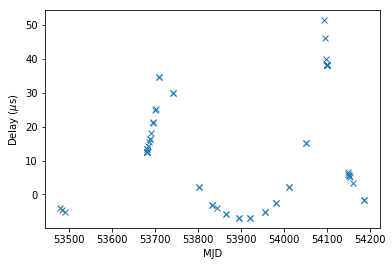

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(t.get_mjds(high_precision=False), ds*1e6, 'x')
plt.xlabel("MJD") ; plt.ylabel("Delay ($\mu$s)")

or all of the terms added together:

In [20]:
m.delay(tt)

array([-256.27780385, -292.17727414, -333.75096918,  357.15222974,
        357.10424491,  357.06652485,  357.03633769,  357.08429712,
        367.69388946,  369.13838938,  379.080215  ,  389.80455011,
        399.7984286 ,  401.11641315,  415.02787367,  435.89826732,
        436.54658382,  454.24106089,  454.72545487,  478.04207904,
        478.38385956,  468.46407861,  467.91561351,   94.36851725,
         92.62907224, -175.81784133, -177.46527042, -253.52910299,
       -394.21626285, -395.23691322, -497.24000468, -497.54026381,
       -488.57105536, -488.1777565 , -337.19429477, -335.91546229,
       -146.57383909, -144.8059907 ,  105.78805673,  107.5422893 ,
        389.24590076,  390.51827027,  490.40921287,  488.47335247,
        484.41365305,  482.68741688,  240.08987512,  226.85717062,
        218.50192024,  209.24145601,  202.56740375,  146.32214659,
        -81.97888773,  -84.14610449,  482.769396  ,  482.74220183,
        482.7182698 ,  482.69709825,  482.67827842,  482.66147

In [21]:
m.phase(tt)

Phase(int=<Column name='tdbld' dtype='float128' length=62>
-1716399977.0
-1689884738.0
-1656989816.0
 -645523228.0
 -645523228.0
 -645523228.0
 -645523228.0
 -645523228.0
 -635828288.0
 -634480136.0
 -625012858.0
 -614385261.0
          ...
 1870800485.0
 1907853722.0
 2050284934.0
 2051643650.0
 1584772976.0
 1584772976.0
 1584772976.0
 1584772976.0
 1584772976.0
 1584772976.0
 1584772976.0
 1584772976.0, frac=<Column name='tdbld' dtype='float128' length=62>
-0.235630831332
-0.240548730944
-0.249681587331
-0.401217052247
-0.401686841971
-0.408011422376
-0.408143698471
-0.405029413057
-0.401967040671
-0.398793970933
-0.399262655992
-0.396772064618
            ...
 -0.24813460093
-0.249303197255
-0.246684764978
-0.244746573968
-0.316759336274
-0.320101340185
-0.323449278018
-0.322321432526
-0.324824381387
-0.319276529714
-0.329714281019
-0.323843126884)

## Residuals

In [22]:
import pint.residuals as r

In [23]:
rs = r.resids(t, m).phase_resids

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/astropy/table/column.py:264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__eq__(other)


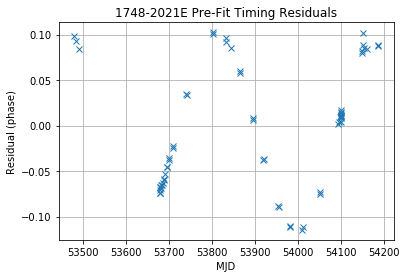

In [24]:
# The get_mjds() function returns float MJDs for easy plotting, rather than astropy Time objects
plt.plot(t.get_mjds(), rs, 'x')
plt.title("%s Pre-Fit Timing Residuals" % m.PSR.value)
plt.xlabel('MJD'); plt.ylabel('Residual (phase)')
plt.grid()


## Fitting and Post-Fit residuals

The fitter is *completely* separate from the model and the TOA code.  So you can use any type of fitter with some easy coding.  This example uses a very simple Powell minimizer from the SciPy optimize module. 

In [25]:
import pint.fitter as fit
f = fit.WlsFitter(t, m)
f.fit_toas()

59.574293804883782028

In [26]:
print("Best fit has reduced chi^2 of", f.resids.chi2_reduced)
print("RMS in phase is", f.resids.phase_resids.std())
print("RMS in time is", f.resids.time_resids.std().to(u.us))
print("\n Best model is:")
print(f.model.as_parfile())


Best fit has reduced chi^2 of 1.04516304921
RMS in phase is 0.00204957448388
RMS in time is 33.3342863834 us

 Best model is:
PSR                            1748-2021E
PLANET_SHAPIRO                          N
DM                          224.113797386 1 0.0349389804941
F0                  61.485476554372500035 1 1.80860843928e-11
F1                     -1.18133163072e-15 1 1.44185403861e-18
TZRMJD              53801.386051182230000
PEPOCH              53750.000000000000000
POSEPOCH            53750.000000000000000
PX                                    0.0
RAJ                     17:48:52.80034692 1 1.04356952778e-11
DECJ                   -20:21:29.38330663 1 2.53484051917e-09
PMRA                                  0.0
PMDEC                                 0.0
UNITS TDB



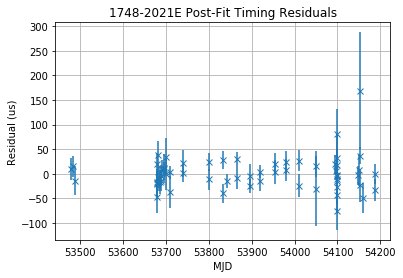

In [27]:
plt.errorbar(t.get_mjds(),
             f.resids.time_resids.to(u.us).value,
             t.get_errors().to(u.us).value, fmt='x')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel('MJD'); plt.ylabel('Residual (us)')
plt.grid()

## Other interesting things

We can make Barycentered TOAs in a single line!

In [28]:
m.get_barycentric_toas(tt)

<Quantity [ 53478.29, 53483.281, 53489.473, 53679.872, 53679.872,
            53679.872, 53679.872, 53679.872, 53681.697, 53681.951,
            53683.733, 53685.734, 53687.683, 53687.946, 53690.846,
            53695.691, 53695.855, 53700.715, 53700.862, 53709.633,
            53709.805, 53740.563, 53740.77, 53801.386, 53801.591,
            53833.301, 53833.505, 53843.336, 53865.19, 53865.381,
            53895.119, 53895.33, 53920.059, 53920.246, 53954.977,
            53955.179, 53980.905, 53981.122, 54010.821, 54011.031,
            54050.701, 54050.942, 54093.652, 54095.648, 54098.66,
            54099.705, 54148.684, 54150.423, 54151.525, 54152.716,
            54153.547, 54160.522, 54187.333, 54187.589, 54099.705,
            54099.705, 54099.705, 54099.705, 54099.705, 54099.705,
            54099.705, 54099.705] d>